In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import os
from glob import glob
from tqdm import tqdm
import numpy as np

import datetime

from  utility_programs.read_routines import SAMI

import cartopy.crs as ccrs

from datetime import datetime
from scipy.spatial import KDTree


# import cartopy.crs as ccrs

: 

: 

In [ ]:
sami_data_path = '/home/axb170054/scratch/from_cheyenne/sami-gitm-coupled-lores'

: 

In [3]:
SAMI = importlib.reload(SAMI)

In [4]:
nz, nf, nlt, nt = SAMI.get_grid_elems_from_parammod(sami_data_path)

old_shape = [nlt, nf, nz]

grid2 = SAMI.get_sami_grid(sami_data_path, nlt, nf, nz)

data2, times = SAMI.read_to_nparray(sami_data_path, datetime(2011,5,20),
                                    datetime(2011,5,21,12), 1, 2, cols='edens')

grid = {};

skipping deni1u.dat because it is not in cols
skipping deni2u.dat because it is not in cols
skipping deni3u.dat because it is not in cols
skipping deni4u.dat because it is not in cols
skipping deni5u.dat because it is not in cols
skipping deni6u.dat because it is not in cols
skipping deni7u.dat because it is not in cols
skipping denn1u.dat because it is not in cols
skipping denn2u.dat because it is not in cols
skipping denn3u.dat because it is not in cols
skipping denn4u.dat because it is not in cols
skipping denn5u.dat because it is not in cols
skipping denn6u.dat because it is not in cols
skipping denn7u.dat because it is not in cols
skipping teu.dat because it is not in cols
skipping ti1u.dat because it is not in cols
skipping ti2u.dat because it is not in cols
skipping ti5u.dat because it is not in cols
skipping vsi1u.dat because it is not in cols
skipping vsi2u.dat because it is not in cols
skipping u1pu.dat because it is not in cols
skipping u3hu.dat because it is not in cols
ski

In [5]:
np.sum(data2['data']['edens']), data2['data']['edens'].shape

(8006212318202.014, (80, 72, 256, 36))

In [6]:
nlt, nf, nz

(80, 72, 256)

In [7]:
# inmask = np.where(grid2['alt'] < 4000, )

In [8]:
for k in grid2.keys():
    grid[k] = grid2[k].flatten()
    grid2[k] = grid2[k]
    print(k, grid[k].shape, grid2[k].shape)

glat (1474560,) (80, 72, 256)
glon (1474560,) (80, 72, 256)
alt (1474560,) (80, 72, 256)
mlat (1474560,) (80, 72, 256)
mlon (1474560,) (80, 72, 256)
malt (1474560,) (80, 72, 256)


In [9]:
"""
- convert to cartesian
- for pt in output grid:
    - find nearest input grid pt.
    - build cube with input grid
    - 3D interpolate (in cartesian)
    - i guess store weigts? somehow?
- save weights.


""";

In [10]:
def latlonalt_to_cart(lat, lon, radius):
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return np.array([x,y,z])

In [11]:
in_cart = latlonalt_to_cart(grid['glat'], grid['glon'], grid['malt'])

In [12]:
latout = np.arange(-90,90,4)
lonout = np.arange(0,360,8)
altout = np.arange(200,2200,100)

out_lats = []
out_lons = []
out_alts = []



for a in latout:
    for o in lonout:
        for l in altout:
            out_lats.append(a)
            out_lons.append(o)
            out_alts.append(l)
            
            

out_cart = latlonalt_to_cart(out_lats, out_lons, np.array(out_alts)+6371)



In [13]:
in_cart.shape, out_cart.shape

((3, 1474560), (3, 40500))

In [15]:
tree = KDTree(in_cart.T)
dists, nearest = tree.query(out_cart.T)

In [75]:
len(np.unique(nearest))

29634

In [76]:
out_lats[0], out_lons[0], out_alts[0]

(-90, 0, 1000)

In [77]:
for k in grid2.keys():
    print(k, grid[k][nearest[0]])

glat -89.005585
glon 303.43784
alt 965.29736
mlat -74.16405
mlon 15.750001
malt 7336.4976


In [78]:

badbadbad = []

badbadbad2 = []


# zero1ddst = np.empty(len(in_cart[0]))
# zero3ddst = np.empty([len(in_cart[1]),3])
zero1dsrc = np.empty([len(out_cart[0]),8])
# zero3dsrc = np.empty([len(out_cart[0]),8,3])


weights = {'weight':zero1dsrc.copy(),
           # 'dstidxs1d':zero1dsrc.copy(),
           'srcidxs1d':zero1dsrc.copy(),}
# print(weights)
# w2 = np.zeros([len(in_cart[0]),len(out_cart[0])])


for n, i in enumerate((nearest)):
    
    l, f, z = np.unravel_index(i, old_shape)
    
    if l == old_shape[0]-1:
        l2 = 0
    else:
        l2 = l+1
    
    if z == 0:
        z2 = -1
    else:
        z2 = z-1
    
    
    f2 = f+1
    if f == old_shape[1]-1:
        badbadbad.append([l,f,z,i,n])
        continue
    
    cs = [[l,  f,  z  ],
          [l,  f,  z2 ],
          [l2, f,  z2 ],
          [l2, f,  z  ],
          [l,  f2, z  ],
          [l,  f2, z  ],
          [l2, f2, z2 ],
          [l2, f2, z2 ],]
    break
#     weights['srcidxs3d'][n] = cs
    
    
    id_pt = []
    xs = []
    ys = []
    zs = []
    for c in cs:
        try:
            index = np.ravel_multi_index(c,old_shape)
        except:
            break
        id_pt.append(index)
        
        xs.append(in_cart[0,index])
        ys.append(in_cart[1,index])
        zs.append(in_cart[2,index])
        
    d = np.sqrt((xs-out_cart[0,n])**2 + (ys-out_cart[1,n])**2 + (zs-out_cart[2,n])**2)
    dtot=np.sum(d)
    
    try:
        weights['weight'][n] = 1/(d)
    except ValueError:
        badbadbad2.append([l,f,z,i,n])
    # weights['weights'].append(d/dtot)
    
    

        
    weights['srcidxs1d'][n]=id_pt


#     weights['dstidxs1d'][n]=i
    
    
    

In [96]:
old_shape

[80, 72, 256]

In [79]:
cs, nearest[0]

([[3, 66, 68],
  [3, 66, 67],
  [4, 66, 67],
  [4, 66, 68],
  [3, 67, 68],
  [3, 67, 68],
  [4, 67, 67],
  [4, 67, 67]],
 72260)

In [80]:
out_cart[0,0], out_cart[1,0], out_cart[2,0], '\n', in_cart[0,nearest[0]], in_cart[1,nearest[0]], in_cart[2,nearest[0]]



(4.5134357782575703e-13, 0.0, -7371.0, '\n', 70.16008, -106.25067, -7335.3926)

In [41]:
# check if point x,y,z = in_cart[:,0] is inside cube defined with corners xs, yz, zs
def is_inside_cube(x,y,z, xs, ys, zs):
    if (x > min(xs)) and (x < max(xs)) and (y > min(ys)) and (y < max(ys)) and (z > min(zs)) and (z < max(zs)):
        return True
    else:
        return False

In [95]:
nlt, nf, nz

(80, 72, 256)

In [16]:
centers = []
coords = []

pbar = tqdm(total=nlt*nf*nz)
badbadbad = []

for l in range(nlt):
    for f in range(nf):
        for z in range(nz):
            
            
            if l == old_shape[0]-1:
                l2 = 0
            else:
                l2 = l+1
            
            if z == 0:
                z2 = -1
            else:
                z2 = z-1
            
            
            f2 = f+1
            if f == old_shape[1]-1:
                badbadbad.append([l,f,z])
                pbar.update()
                continue
            
            cs = [[l,  f,  z  ],
                [l,  f,  z2 ],
                [l2, f,  z2 ],
                [l2, f,  z  ],
                [l,  f2, z  ],
                [l,  f2, z  ],
                [l2, f2, z2 ],
                [l2, f2, z2 ],]
            
            for c in cs:
                id_pt = []
                xs = []
                ys = []
                zs = []
                for c in cs:
                    try:
                        index = np.ravel_multi_index(c,old_shape)
                    except:
                        pbar.update()
                        break
                    id_pt.append(index)
                    
                    xs.append(in_cart[0,index])
                    ys.append(in_cart[1,index])
                    zs.append(in_cart[2,index])
                    
            center = np.sum(xs)/8, np.sum(ys)/8, np.sum(zs)/8
            
            centers.append(center)
            coords.append(cs)
            pbar.update()
                    

1519712it [18:52, 1398.29it/s]                             

In [17]:
np.array(centers).shape

(1454080, 3)

In [18]:
len(badbadbad), len(centers), in_cart.shape

(20480, 1454080, (3, 1474560))

In [23]:
out_cart.shape

(3, 40500)

In [20]:
tree = KDTree(centers)
dists, nearest = tree.query(out_cart.T)

In [21]:
nearest.shape

(40500,)

In [62]:
ins = 0
weights = np.zeros([len(out_cart[0]), 8])
src_idxs = np.zeros([len(out_cart[0]),8])
for n, pt in enumerate(tqdm(nearest)):
    
    idxs = [np.ravel_multi_index(c,old_shape) for c in coords[pt]]
    
    xs = in_cart[0,idxs]
    ys = in_cart[0,idxs]
    zs = in_cart[2, idxs]
    
    val = is_inside_cube(out_cart[0,n], out_cart[1,n], out_cart[2,n],
                         xs, ys, zs)
    if val:
        d = np.sqrt((xs-out_cart[0,n])**2 + (ys-out_cart[1,n])**2 + (zs-out_cart[2,n])**2)
                
        weights[n] = 1/(d)
        
        src_idxs[n] = idxs
    

100%|██████████| 40500/40500 [00:03<00:00, 11732.07it/s]


In [70]:


out = []
for t in range(t0.shape[-1]):
    out.append(np.sum(weights['weight'] * np.take(t0[:,:,:,t],weights['srcidxs1d'].astype(int)), axis=1) / np.sum(weights['weight'], axis=1))

NameError: name 't0' is not defined

In [ ]:
ds =  xr.Dataset(coords={
    'time':(['time'],times),
    'alt':(['alt'],altout),
    'lat':(['lat'],latout),
    'lon':(['lon'],lonout)},
                     data_vars={
                         'dene':(['time','lat','lon','alt'],
                                 out.reshape(len(times),len(latout), len(lonout), len(altout)))})

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (time: 36, lat: 360, lon: 720, alt: 42)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-21T11:00:00 ... 2011-05-21T13:55:00
  * alt      (alt) int64 100 150 200 250 300 350 ... 1950 2000 2050 2100 2150
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
Data variables:
    dene     (time, lat, lon, alt) float64 0.0 0.0 0.0 ... 3.813e+03 3.802e+03

In [68]:
latout2 = np.arange(-90,90,1)
lonout2 = np.arange(0,360,4)
altout2 = np.arange(100,2200,50)

In [69]:
ds2 = xr.Dataset(coords={
    'time':(['time'],times),
    'alt':(['alt'],altout2),
    'lat':(['lat'],latout2),
    'lon':(['lon'],lonout2)},
                     )

In [ ]:
ds3 = ds.interp_like(ds2, method='linear')

In [ ]:
ds3

<xarray.Dataset>
Dimensions:  (time: 36, lat: 180, lon: 90, alt: 42)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-21T11:00:00 ... 2011-05-21T13:55:00
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 4 8 12 16 20 24 28 ... 332 336 340 344 348 352 356
  * alt      (alt) int64 100 150 200 250 300 350 ... 1950 2000 2050 2100 2150
Data variables:
    dene     (time, lat, lon, alt) float64 0.0 0.0 0.0 ... 3.855e+03 3.845e+03

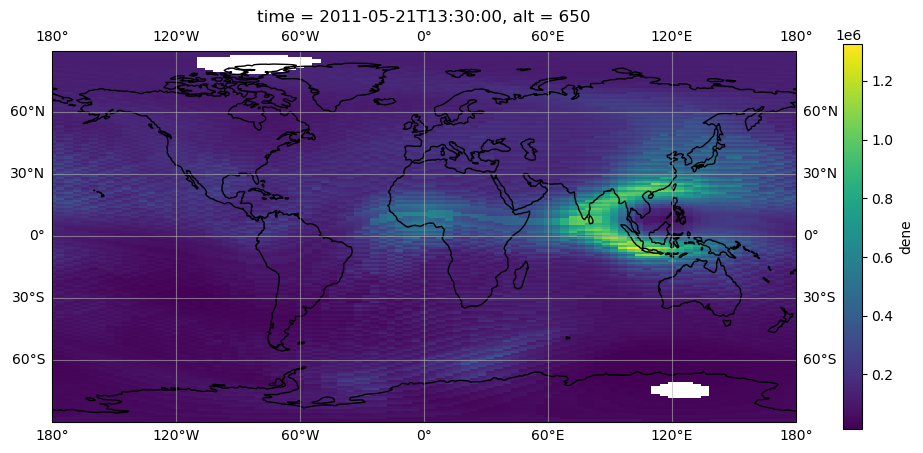

In [ ]:
plt.figure(figsize = (12,5))
ax = plt.subplot(projection=ccrs.PlateCarree(), )
ds3.dene.sel(alt=650, method='nearest').isel(time=30).plot(ax = ax)
ax.coastlines()
ax.gridlines(draw_labels = True, alpha = 0.6)
plt.show()
plt.close()


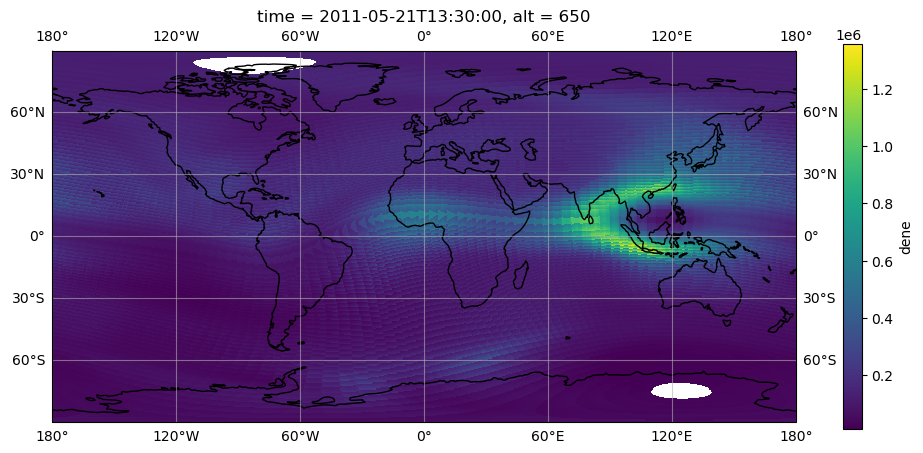

In [ ]:
plt.figure(figsize = (12,5))
ax = plt.subplot(projection=ccrs.PlateCarree(), )
ds.dene.sel(alt=650, method='nearest').isel(time=30).plot(ax = ax)
ax.coastlines()
ax.gridlines(draw_labels = True, alpha = 0.6)

In [64]:
a = np.array([1,2,3])
a.tofile('test')

In [65]:
ds

NameError: name 'ds' is not defined

In [66]:
ds2

NameError: name 'ds2' is not defined

In [71]:
ds4 = ds.coarsen(lat=4,lon=8).mean()

In [72]:
ds4

<xarray.Dataset>
Dimensions:  (time: 36, lat: 90, lon: 90, alt: 42)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-21T11:00:00 ... 2011-05-21T13:55:00
  * alt      (alt) int64 100 150 200 250 300 350 ... 1950 2000 2050 2100 2150
  * lat      (lat) float64 -89.25 -87.25 -85.25 -83.25 ... 84.75 86.75 88.75
  * lon      (lon) float64 1.75 5.75 9.75 13.75 ... 345.8 349.8 353.8 357.8
Data variables:
    dene     (time, lat, lon, alt) float64 0.0 0.0 0.0 ... 3.843e+03 3.833e+03

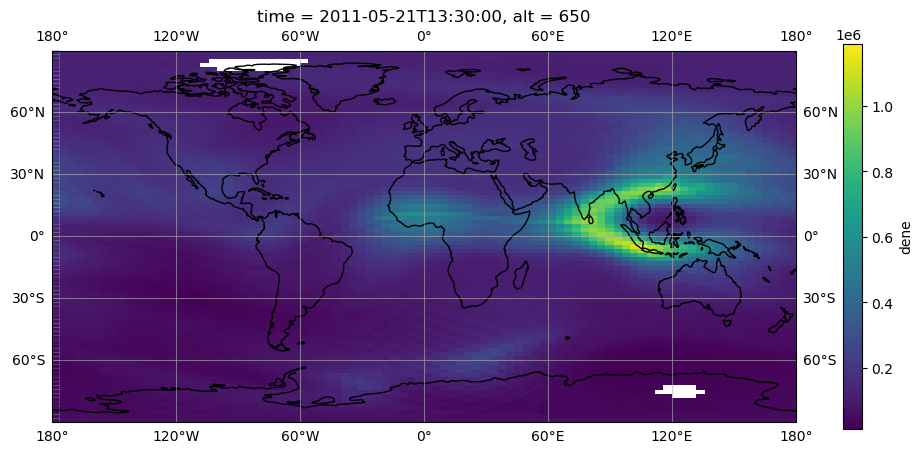

In [73]:
plt.figure(figsize = (12,5))
ax = plt.subplot(projection=ccrs.PlateCarree(), )
ds4.dene.sel(alt=650, method='nearest').isel(time=30).plot(ax = ax, aa=True)
ax.coastlines()
ax.gridlines(draw_labels = True, alpha = 0.6)

In [36]:
itime=30
nalt=650

m = np.where((grid['alt'] > nalt*.95) & (grid['alt'] < nalt*1.05))

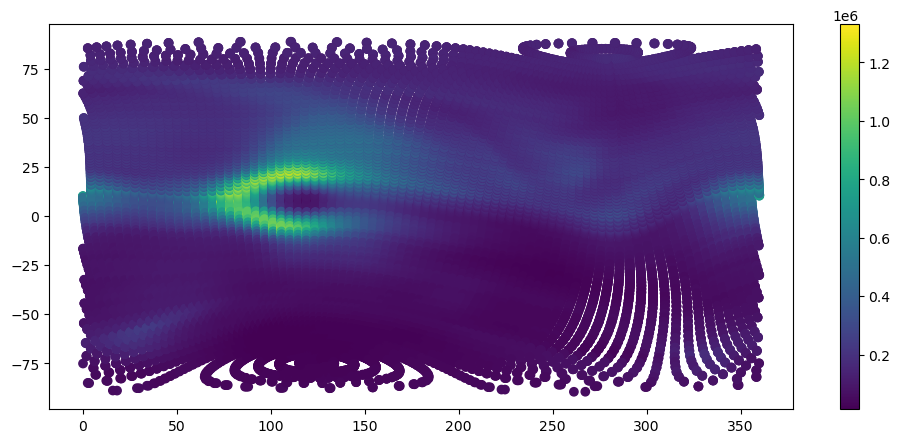

In [48]:
plt.figure(figsize = (12,5))

plt.scatter(grid['glon'][m], grid['glat'][m], c=data2['data']['edens'][:,:,:,itime].flatten()[m])
plt.colorbar()
plt.show()
plt.close()

In [31]:
plt.imshow(out.reshape(len(latout), len(lonout), len(altout))[:,:,5], interpolation = 'bicubic', interpolation_stage='rgba')

ValueError: cannot reshape array of size 48988800 into shape (180,360,21)